In [2]:
import sys
import os
import glob
import zipfile

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import gridspec, patches, cm

sys.path.append("..")
import util.io as io
from util.plot import add_panel_letters, add_brain_regions, add_mask

%matplotlib inline

In [10]:
def mark(axes, x, y, **args):
    defargs = dict(ec='k', lw=0.5, zorder=10, clip_on=False)
    defargs.update(args)
    for ax in axes:
        ax.scatter(x, y, **defargs)  

## z and seizure plot with simulated data

In [3]:
def expbilin(y, c, q):
    c1, c2 = -1, 1
    y1, y2 = 0, 1
    q11, q12, qa21, qa22 = q
    q21 = q11 + qa21
    q22 = q12 + qa22

    return np.exp(1./((c2 - c1)*(y2 - y1)) * (  q11*(c2 - c)*(y2 - y) + q21*(c - c1)*(y2 - y)
                                              + q12*(c2 - c)*(y - y1) + q22*(c - c1)*(y - y1)))

def prop(c, w, q, nt=1000):
    TLIM = 90.0
    
    nreg = len(c)

    t = np.zeros(nreg)

    x = np.zeros(nreg, dtype=int)
    z = np.zeros(nreg, dtype=float)
    
    
    ts = np.linspace(0, TLIM, nt, endpoint=True)
    zs = np.zeros((nreg, nt), dtype=float)

    regs = np.r_[:nreg]

    time = 0.0
    for i in range(nreg):
        y = np.dot(w, x)
        fy = expbilin(y, c, q)

        # First to switch
        dts = np.divide(1.0 - z, fy, out=np.Inf * np.ones_like(fy), where=fy!=0)

        mask = x < 0.5
        dt, reg_to_switch = min(zip(dts[mask], regs[mask]))

        if np.isinf(dt):
            raise ValueError("Numerical error")
        
        tmask = (ts >= time) * (ts < time + dt)
        for reg in range(nreg):
            zs[reg, tmask] = np.linspace(z[reg], z[reg] + dt*fy[reg], np.sum(tmask), endpoint=False)
            

        z += dt * fy

        time += dt
        x[reg_to_switch] = 1
        t[reg_to_switch] = time        
        

    return t, ts, zs

In [5]:
w = np.genfromtxt("../data/conn/vep/id001.txt")
nreg = w.shape[0]

In [6]:
q = [-12.699722249999999, 15.479622175000001, 5.527035135, 75.21215649999999]

In [7]:
np.random.seed(64)
c = np.random.normal(0, 1, nreg)

In [8]:
t, ts, zs = prop(c, w, q)

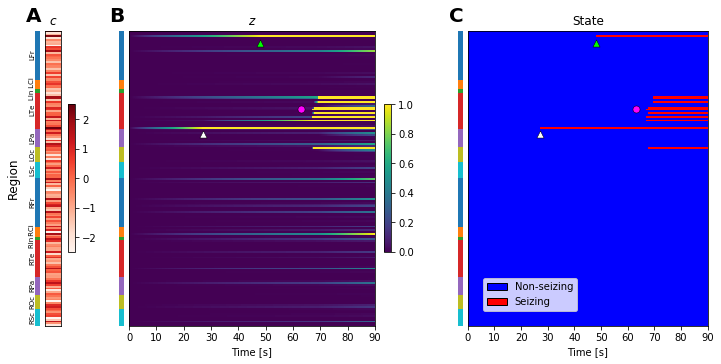

In [13]:
fig = plt.figure(figsize=(10, 5))

gs = gridspec.GridSpec(1, 3, width_ratios=[0.15, 1, 0.8], wspace=0.2,
                       left=0.06, right=0.98, top=0.92, bottom=0.1)

ax0 = plt.subplot(gs[0])
plt.imshow(c[:, None], vmin=-2.5, vmax=2.5, aspect='auto', origin='upper', cmap='Reds', extent=[0, 1, nreg, 0])
plt.colorbar(shrink=0.5, pad=0.15, fraction=0.5)
plt.xticks([]);
plt.xlim(0, 1)
add_brain_regions(ax0, pad=5, width=5, coord='display')
plt.title("$c$")
plt.ylabel("Region", labelpad=25, fontsize=12)

ax1 = plt.subplot(gs[1])
plt.imshow(zs, vmin=0, vmax=1, aspect='auto', origin='upper', extent=[0, 90.0, nreg, 0])
plt.colorbar(shrink=0.5, pad=0.03)
plt.xlim(0, 90.)
plt.title("$z$")
# plt.yticks([])
add_brain_regions(ax1, labels=False, pad=5, width=5, coord='display')
plt.xlabel("Time [s]")
plt.xticks(np.r_[0:91:10])

ax2 = plt.subplot(gs[2])
plt.imshow(zs >= 1., vmin=0, vmax=1, cmap='bwr', aspect='auto', origin='upper', extent=[0, 90.0, nreg, 0])
plt.xlim(0, 90.)
add_brain_regions(ax2, labels=False, pad=5, width=5, coord='display')
plt.title("State")
plt.xlabel("Time [s]")
plt.xticks(np.r_[0:91:10])


legend_elements = [patches.Patch(facecolor='b', edgecolor='k', label="Non-seizing"),
                   patches.Patch(facecolor='r', edgecolor='k', label="Seizing")]
ax2.legend(handles=legend_elements, loc='lower left', borderaxespad=1.5)

add_panel_letters(fig, [ax0, ax1, ax2], fontsize=20, xpos=[-1.2, -0.08, -0.08], ypos=1.03)

mark([ax1, ax2], 27, 57, marker='^', color='white',   s=50)
mark([ax1, ax2], 48,  7, marker='^', color='lime',    s=50)
mark([ax1, ax2], 63, 43, marker='o', color='magenta', s=50)

plt.savefig("img/simulated-seizure.pdf", dpi=300)